In [8]:
import nltk
nltk.download("vader_lexicon", quiet=False)
import os
import sys
import math
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import missingno as msno
import plotly.express as px
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yigitkinali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df = pd.read_csv("Datasets/train_dataset.csv", encoding="latin1")
df.drop(columns=["selected_text"], inplace=True)
df.drop(columns=["Population -2020"], inplace=True)
df.drop(columns=["Land Area (Km²)"], inplace=True)
df.drop(columns=["Density (P/Km²)"], inplace=True)
df.to_csv("clean_train.csv", index=False, encoding="latin1")
print(df.shape)
df.head(6)
df["Country"].nunique()
print(df['sentiment'].value_counts())
print(df["sentiment"].value_counts(normalize=True) * 100)

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/train_dataset.csv'

In [4]:
ct = pd.crosstab(df["Time of Tweet"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Time of Tweet vs Sentiment")
plt.ylabel("Time of Tweet")
plt.xlabel("Sentiment")
plt.show()

ct = pd.crosstab(df["Age of User"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Reds")
plt.title("Age of User vs Sentiment")
plt.ylabel("Age of User")
plt.xlabel("Sentiment")
plt.show()

NameError: name 'pd' is not defined

In [2]:
# Features like Time of Tweet, Age of user, Country are used.!!

# 2) Etiket normalizasyonu (pos/neg/neu)
def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)

# 3) Feature ve target
cat_feats = ["Age of User","Time of Tweet","Country"]
X = df[["text"] + cat_feats]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Pipeline: TF-IDF + OneHot + SVM
text_vec = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)
cat_enc  = OneHotEncoder(handle_unknown="ignore")

preproc = ColumnTransformer(transformers=[
    ("text", text_vec, "text"),
    ("cat",  cat_enc,  cat_feats)
])

clf = Pipeline([
    ("prep", preproc),
    ("svm", LinearSVC(C=1.0, class_weight="balanced", random_state=42))
])

# 5) Model Training and Evaluation
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, labels=present, digits=3))
print("Overall Accuracy:", accuracy_score(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=present)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=present, yticklabels=present)
plt.title("Confusion Matrix (TF-IDF + Age + Time + Country + SVM)", fontsize=13)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

NameError: name 'df' is not defined

In [6]:
# Features are not used.!!

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Etiket normalizasyonu (pos/neg/neu)
def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)

# 2) Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)

# 3) Pipeline: TF-IDF + MultinomialNB
nb_clf = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("nb",    MultinomialNB(alpha=1.0))  # alpha: Laplace/Lidstone smoothing
])

nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

print("=== MultinomialNB Classification Report ===")
print(classification_report(y_test, y_pred, labels=present, digits=3))
print("Overall Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=present)
ConfusionMatrixDisplay(cm, display_labels=present).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (TF-IDF only + MultinomialNB)")
plt.show()

NameError: name 'df' is not defined

                                                text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                                    sentiment_scores sentiment_found  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...         neutral  
1  {'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...        negative  
2  {'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'comp...        negative  
3  {'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'comp...        negative  
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...         neutral  


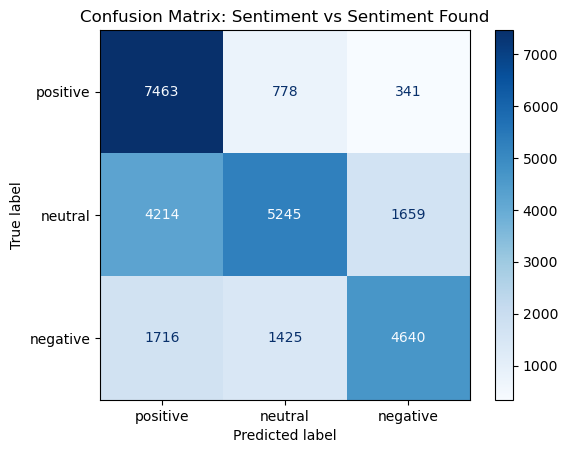

=== Classification Report ===
              precision    recall  f1-score   support

    positive      0.557     0.870     0.679      8582
     neutral      0.704     0.472     0.565     11118
    negative      0.699     0.596     0.644      7781

    accuracy                          0.631     27481
   macro avg      0.653     0.646     0.629     27481
weighted avg      0.657     0.631     0.623     27481

Overall Accuracy: 0.631


In [54]:
# 3. VADER analizörü
sia = SentimentIntensityAnalyzer()

# 4. Skorları hesapla
df["sentiment_scores"] = df["text"].apply(lambda x: sia.polarity_scores(str(x)))

# 5. Compound skoruna göre sınıf ata
def vader_label(score_dict):
    c = score_dict["compound"]
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_found"] = df["sentiment_scores"].apply(vader_label)

df.to_csv("sentiment_lexicon-based.csv", index=False, encoding="latin1")

# 6. Sonuçlara göz at
print(df[["text", "sentiment_scores", "sentiment_found"]].head())
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)

# Gerçek ve tahmin etiketleri seç
true_labels = df["sentiment"]
pred_labels = df["sentiment_found"]

# --- Confusion Matrix ---
labels = ["positive", "neu", "neg"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: Sentiment vs Sentiment Found")
plt.show()

# --- Classification Report (Precision, Recall, F1, Support) ---
print("=== Classification Report ===")
print(classification_report(true_labels, pred_labels, labels=labels, digits=3))

# --- Accuracy ---
acc = accuracy_score(true_labels, pred_labels)
print(f"Overall Accuracy: {acc:.3f}")